# prompting the past

Distant reading code for the [Prompting the Past DH 2024 proposal](https://github.com/inactinique/DH2024_prompting_the_past/). This code has been written with the help of different LLMs (ChatGPT and then Claure) as well as local LLMs (codellama). I am using LLMs in two ways: to help me write code, but also to control the code written aitomatically by asking another (local) LLM to explain it (mistral-7b-instruct). 

This is a work in progress.

## Required library / python version

### python version

In [1]:
!python --version

Python 3.9.18


Python 3.9.18

### required libraries

- gensim (gensim-4.3.2 numpy-1.26.2 scipy-1.11.4 smart-open-6.4.0)
- pandas (pandas-2.1.3 pytz-2023.3.post1 tzdata-2023.3)
- nltk (click-8.1.7 nltk-3.8.1 regex-2023.10.3 tqdm-4.66.1)
- pyLDAvis (MarkupSafe-2.1.3 funcy-2.0 jinja2-3.1.2 joblib-1.3.2 numexpr-2.8.7 pyLDAvis-3.4.1 scikit-learn-1.3.2 setuptools-69.0.2 threadpoolctl-3.2.0)
- matplotlib (contourpy-1.2.0 cycler-0.12.1 fonttools-4.46.0 kiwisolver-1.4.5 matplotlib-3.8.2 pyparsing-3.1.1)
- networkx-3.2.1
- plotly (plotly-5.18.0 tenacity-8.2.3)
-  fastjsonschema-2.19.0 jsonschema-4.20.0 jsonschema-specifications-2023.11.2 nbformat-5.9.2 referencing-0.31.1 rpds-py-0.13.2

In [2]:
# Install necessary libraries if you haven't already
# !pip install gensim
# !pip install numpy
# !pip install nltk 
# !pip install pyLDAvis
# !pip install matplotlib
# !pip install networkx
# !pip install plotly
# !pip install nbformat
# !pip install re
# !pip install pandas
# !pip install scikit==1.12.0
# !pip install wordcloud

## Filtering and pre-processing of the corpus

We will use the [open-promtps corpus](krea) from [krea.ai](https://krea.ai). This corpus is, to my knowledge (February 2024), the largest corpus of prompts you can get. Beware, it's more than 10 million lines. I chose to download the csv file, but there is also the possibility to use the krea API.

### import libraries

In [3]:
# We start by importinf the required libraries
from gensim import corpora
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from pprint import pprint
import nltk
from nltk.corpus import stopwords
import csv
import re

### load the corpus

In [4]:
# Here we load the corpus. It is made of 10 778 778 rows

corpus_file = 'data/prompts.csv'
corpus_prefilter = []

# Read the csv file

with open(corpus_file, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    header = next(reader) # This will store the first row (header) in a variable
    for row in reader:
        corpus_prefilter.append(row[0]) # only append the first column of each row

### filter the corpus

In [5]:
# As the aim of my DH2024 paper is to investigate prompts related to the past, we are filtering the corpus: we wanrt all rows with a word starting with 'histor' or containing 'past'. This is a very and too simple approach that will be refined later. It's a research that is starting. 

corpus = [text for text in corpus_prefilter if re.search(r'\bhistor', text.lower()) or 'past' in text.lower()]

In [6]:
# we look a bit at the colume of the corpus, as well as display the few first lines and the few last lines.

print("Number of rows in the corpus", len(corpus))
print("First 5 elements:", corpus[:5])
print("Last 5 elements:", corpus[-5:])

Number of rows in the corpus 140453
First 5 elements: ['epic portrait mona lisa eating an apple, beauty, pretty face, glossy skin, shiny, wet hair, digital painting, artstation, concept art, soft light, hdri, smooth, sharp focus, illustration, fantasy, intricate, elegant, highly detailed, D&D, matte painting, in the style of Greg Rutkowski and Alphonse Mucha and artemisia, 8k, highly detailed, jurgens, rutkowski, bouguereau, pastoral, rustic, georgic', 'high quality high detail painting by norman rockwell, hd, close up portrait, pretty young woman, muted pastel colors, photorealistic lighting', 'Concept art Portrait of the ancient historical biblical SNARLING ANGRYING YELLING, jealous king Saul of Israel by craig mullins and marc simonetti, ARTSTATION, cgsociety, polycount, character design, CINEMATIC, AWE INSPIRING, BEAUTIFUL, ART GERM', 'telephoto 7 0 mm f / 2. 8 iso 2 0 0 photograph depicting the feeling of chrysalism in a cosy safe cluttered french sci - fi ( art nouveau ) cyberpun

### save the filtered corpus

Here we save the filtered (but not yet pre-processed) corpus in order to use it in other pieces of software (for instance [IRaMuTeQ](http://iramuteq.org)).

In [7]:
with open("data_generated/filtered_corpus_histor.txt", "w", encoding='utf-8') as file:
    file.writelines(f"{item}\n" for item in corpus)

### pre-processing

In [8]:
# Here, we want to remove stopwords, tokenize, create a dictionnary, filter out few used words

# we disable ssl checking, otherwise nltk.download won't work. [Other solutions are available here](https://stackoverflow.com/questions/41348621/ssl-error-downloading-nltk-data). uncomment if necessary (if nltk_data is not downloaded)

# import ssl
#try:
#    _create_unverified_https_context = ssl._create_unverified_context
#except AttributeError:
#    pass
#else:
#    ssl._create_default_https_context = _create_unverified_https_context
# nltk stopwords

# We now import NLTK stopwords

stop_words = set(stopwords.words('english'))

# We define a function that will tokenize and clean the texts
def preprocess_text(text):
    # Convert to lowercase and remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]
    # Remove tokens made of more than 4 numbers -- for a strange reason, there are lots of them
    tokens = [word for word in tokens if not (word.isdigit() and len(word) > 4)]
    return tokens

# Tokenize and clean the entire corpus by using the function we defined earlier, preprocess_text
tokenized_texts = [preprocess_text(text) for text in corpus]

# We create a dictionary representation of the documents
# The dictionary will be used to create bags of words later.

from gensim.corpora import Dictionary
dictionary = Dictionary(tokenized_texts)

# We filter out words that occur less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [9]:
# We save the tokenized corpus

with open("data_generated/preprocess_corpus_histor.txt", "w", encoding='utf-8') as file:
    file.writelines(f"{item}\n" for item in tokenized_texts)

### More stats

In [10]:
# We now want to have some more basic statistics about our corpus. 

# Count tokens for each row in the corpus
token_counts = [len(preprocess_text(row)) for row in corpus]

# Print the counts
for i, count in enumerate(token_counts):
    print(f"Row {i + 1} has {count} tokens")

# If you want the total count across all rows
total_tokens = sum(token_counts)
print(f"Total number of tokens across all rows: {total_tokens}")

# If you want some basic statistics
import statistics

average_tokens = statistics.mean(token_counts)
median_tokens = statistics.median(token_counts)
max_tokens = max(token_counts)
min_tokens = min(token_counts)

print(f"Average tokens per row: {average_tokens:.2f}")
print(f"Median tokens per row: {median_tokens}")
print(f"Maximum tokens in a row: {max_tokens}")
print(f"Minimum tokens in a row: {min_tokens}")

Row 1 has 47 tokens
Row 2 has 17 tokens
Row 3 has 28 tokens
Row 4 has 25 tokens
Row 5 has 31 tokens
Row 6 has 8 tokens
Row 7 has 10 tokens
Row 8 has 27 tokens
Row 9 has 16 tokens
Row 10 has 16 tokens
Row 11 has 17 tokens
Row 12 has 26 tokens
Row 13 has 48 tokens
Row 14 has 65 tokens
Row 15 has 37 tokens
Row 16 has 25 tokens
Row 17 has 39 tokens
Row 18 has 172 tokens
Row 19 has 19 tokens
Row 20 has 31 tokens
Row 21 has 29 tokens
Row 22 has 13 tokens
Row 23 has 27 tokens
Row 24 has 17 tokens
Row 25 has 19 tokens
Row 26 has 28 tokens
Row 27 has 46 tokens
Row 28 has 45 tokens
Row 29 has 27 tokens
Row 30 has 37 tokens
Row 31 has 24 tokens
Row 32 has 26 tokens
Row 33 has 11 tokens
Row 34 has 158 tokens
Row 35 has 37 tokens
Row 36 has 16 tokens
Row 37 has 14 tokens
Row 38 has 6 tokens
Row 39 has 74 tokens
Row 40 has 38 tokens
Row 41 has 30 tokens
Row 42 has 21 tokens
Row 43 has 45 tokens
Row 44 has 12 tokens
Row 45 has 19 tokens
Row 46 has 30 tokens
Row 47 has 31 tokens
Row 48 has 35 tokens
R

## Topic modelling (LDA)


We now want to see the main topics that are in our corpus.

In [11]:
# Create a bag-of-words representation of the documents
corpus_bow = [dictionary.doc2bow(text) for text in tokenized_texts]

# Train the LDA model
num_topics = 150  # You can adjust this parameter based on your requirements
lda_model = LdaModel(corpus_bow, num_topics=num_topics, id2word=dictionary, passes=15)

# Print the topics and their top words
pprint(lda_model.print_topics())

[(147,
  '0.141*"dark" + 0.102*"night" + 0.094*"ancient" + 0.058*"top" + '
  '0.055*"fantasy" + 0.053*"ornate" + 0.048*"art" + 0.042*"ring" + '
  '0.039*"background" + 0.036*"marbled"'),
 (128,
  '0.067*"grey" + 0.057*"alex" + 0.055*"colors" + 0.041*"mountains" + '
  '0.041*"artstation" + 0.040*"trending" + 0.037*"painting" + 0.027*"render" + '
  '0.024*"candy" + 0.023*"light"'),
 (127,
  '0.110*"render" + 0.106*"detailed" + 0.086*"octane" + 0.081*"art" + '
  '0.060*"details" + 0.056*"ultra" + 0.056*"full" + 0.045*"intricate" + '
  '0.043*"concept" + 0.040*"painting"'),
 (75,
  '0.030*"smoke" + 0.030*"lots" + 0.026*"sparkling" + 0.026*"walls" + '
  '0.024*"arms" + 0.022*"birds" + 0.021*"landscape" + 0.018*"psychedelic" + '
  '0.017*"stone" + 0.017*"sun"'),
 (138,
  '0.039*"light" + 0.035*"black" + 0.031*"male" + 0.029*"rock" + 0.027*"waves" '
  '+ 0.027*"environment" + 0.027*"colours" + 0.027*"three" + '
  '0.026*"photographic" + 0.026*"art"'),
 (121,
  '0.183*"holding" + 0.114*"modern

### Visualize topics

In [12]:
# We use pyLDAvis to see our topics. 
# Import library
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Visualize topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus_bow, dictionary)
pyLDAvis.display(vis)


### We also want to visualize topics that contains 'past' or all words starting with 'histor'.

In [14]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import LdaModel
import re

# Function to check if a word matches our criteria
def word_matches(word):
    return word == 'past' or word.startswith('histor')

# Find topics that contain our target words
target_topics = []
for topic_id in range(lda_model.num_topics):
    topic_words = dict(lda_model.show_topic(topic_id, topn=50))  # Get top 50 words for each topic
    if any(word_matches(word) for word in topic_words.keys()):
        target_topics.append(topic_id)

# Create a new LDA model with only the target topics
filtered_lda_model = LdaModel(
    num_topics=len(target_topics),
    id2word=dictionary,
    alpha='auto',
    passes=10
)

# Copy the state of the target topics to the new model
for new_id, old_id in enumerate(target_topics):
    filtered_lda_model.state.sstats[new_id] = lda_model.state.sstats[old_id]

# Update the model
filtered_lda_model.sync_state()

# Visualize topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(filtered_lda_model, corpus_bow, dictionary)
pyLDAvis.display(vis)

## Vectors

We will now use word2ve. THe aim here is to compare a bit what we can do with LDA and what we can do with word vectors.

In [15]:
# If you already have a pre-trained model, then you don't need to recreate it. Go to next cell.
# Import libraries
from gensim.models import Word2Vec
import re

# Read the corpus from the file

# with open(corpus_file, 'r', encoding='utf-8') as file:
#    corpus = [line.strip() for line in file]

# Import NLTK stopwords
stop_words = set(stopwords.words('english'))

# Tokenize and clean the texts
def preprocess_text(text):
    # Convert to lowercase and remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]
    # Remove tokens made of more than 4 numbers
    tokens = [word for word in tokens if not (word.isdigit() and len(word) > 4)]
    return tokens

# Tokenize and clean the entire corpus
tokenized_corpus = [preprocess_text(text) for text in corpus]

# Train the Word2Vec model
# replace by tokenized_corpus if necessary.
model_w2v = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=5, workers=4)

# Save the model for future use
model_w2v.save('data_generated/word2vec_model.model')

# Example usage: find similar words to a given word
similar_words = model_w2v.wv.most_similar('napoleon', topn=5)
print("Similar words to 'napoleon':", similar_words)


Similar words to 'napoleon': [('bolognese', 0.5791522264480591), ('ue6', 0.5723574161529541), ('kubrick', 0.5596467852592468), ('anchovies', 0.5573458075523376), ('fullbody', 0.5544193983078003)]


In [16]:
# if you already have a pretrained model, then load it first
from gensim.models import Word2Vec

# Load pre-trained Word2Vec model.
model_w2v = Word2Vec.load("data_generated/word2vec_model.model")

# Example usage: find similar words to a given word
similar_words = model_w2v.wv.most_similar('history', topn=500)
print("Similar words to 'history':", similar_words)

Similar words to 'history': [('greatest', 0.5447473526000977), ('transfer', 0.5289018750190735), ('channel', 0.5190851092338562), ('wealth', 0.5179757475852966), ('america', 0.48884183168411255), ('regime', 0.4868893325328827), ('alternate', 0.48646631836891174), ('museum', 0.4792459011077881), ('demonstration', 0.47347137331962585), ('kiara', 0.45424020290374756), ('satanic', 0.45009708404541016), ('freedom', 0.4493507742881775), ('wrong', 0.44930315017700195), ('textbook', 0.4475513696670532), ('ussa', 0.44325417280197144), ('catalog', 0.44077351689338684), ('hermitage', 0.43822604417800903), ('thousands', 0.4360654354095459), ('dimensions', 0.4359513819217682), ('advani', 0.4329519271850586), ('twentieth', 0.43288180232048035), ('vitrine', 0.432160884141922), ('worst', 0.42881670594215393), ('slaves', 0.4273851215839386), ('roos', 0.427376389503479), ('loading', 0.4229806363582611), ('windowstore', 0.42175883054733276), ('widest', 0.4216851592063904), ('designated', 0.42146173119544

### Let's visualize some word vectors

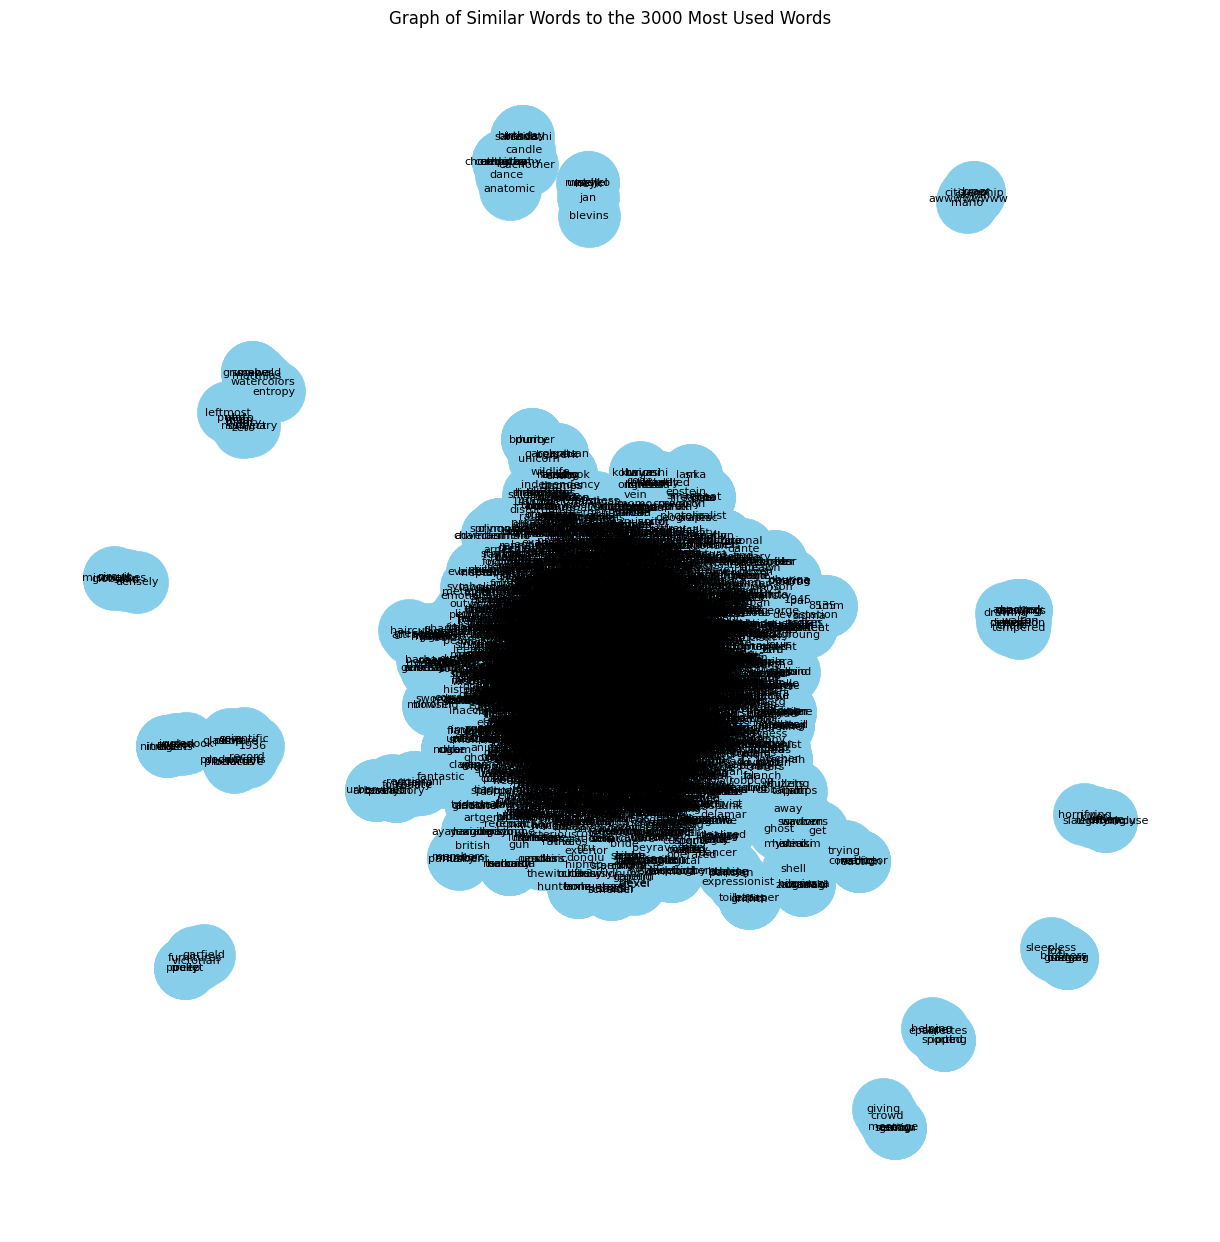

In [17]:
# Import libraries
import matplotlib.pyplot as plt
import networkx as nx

# Get the 3000 most used words in the corpus
most_used_words = model_w2v.wv.index_to_key[:3000]

# Create a graph
G = nx.Graph()

# Add nodes for the most used words
G.add_nodes_from(most_used_words)

# Add edges between each word and its similar words
for word in most_used_words:
    similar_words = model_w2v.wv.most_similar(word, topn=5)
    for similar_word, _ in similar_words:
        G.add_edge(word, similar_word)

# Plot the graph
pos = nx.spring_layout(G, seed=42)  # Set seed for reproducibility
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, font_size=8, node_size=2000, font_color='black', node_color='skyblue', edge_color='gray', linewidths=0.5)
plt.title('Graph of Similar Words to the 3000 Most Used Words')
plt.show()


In [18]:
# export the graph in GraphML format
nx.write_graphml(G, "data_generated/word_similarity_graph.graphml")

/var/folders/90/j99p488148vcmjxgs16_mq0j42556r/T/ipykernel_54310/3382394419.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


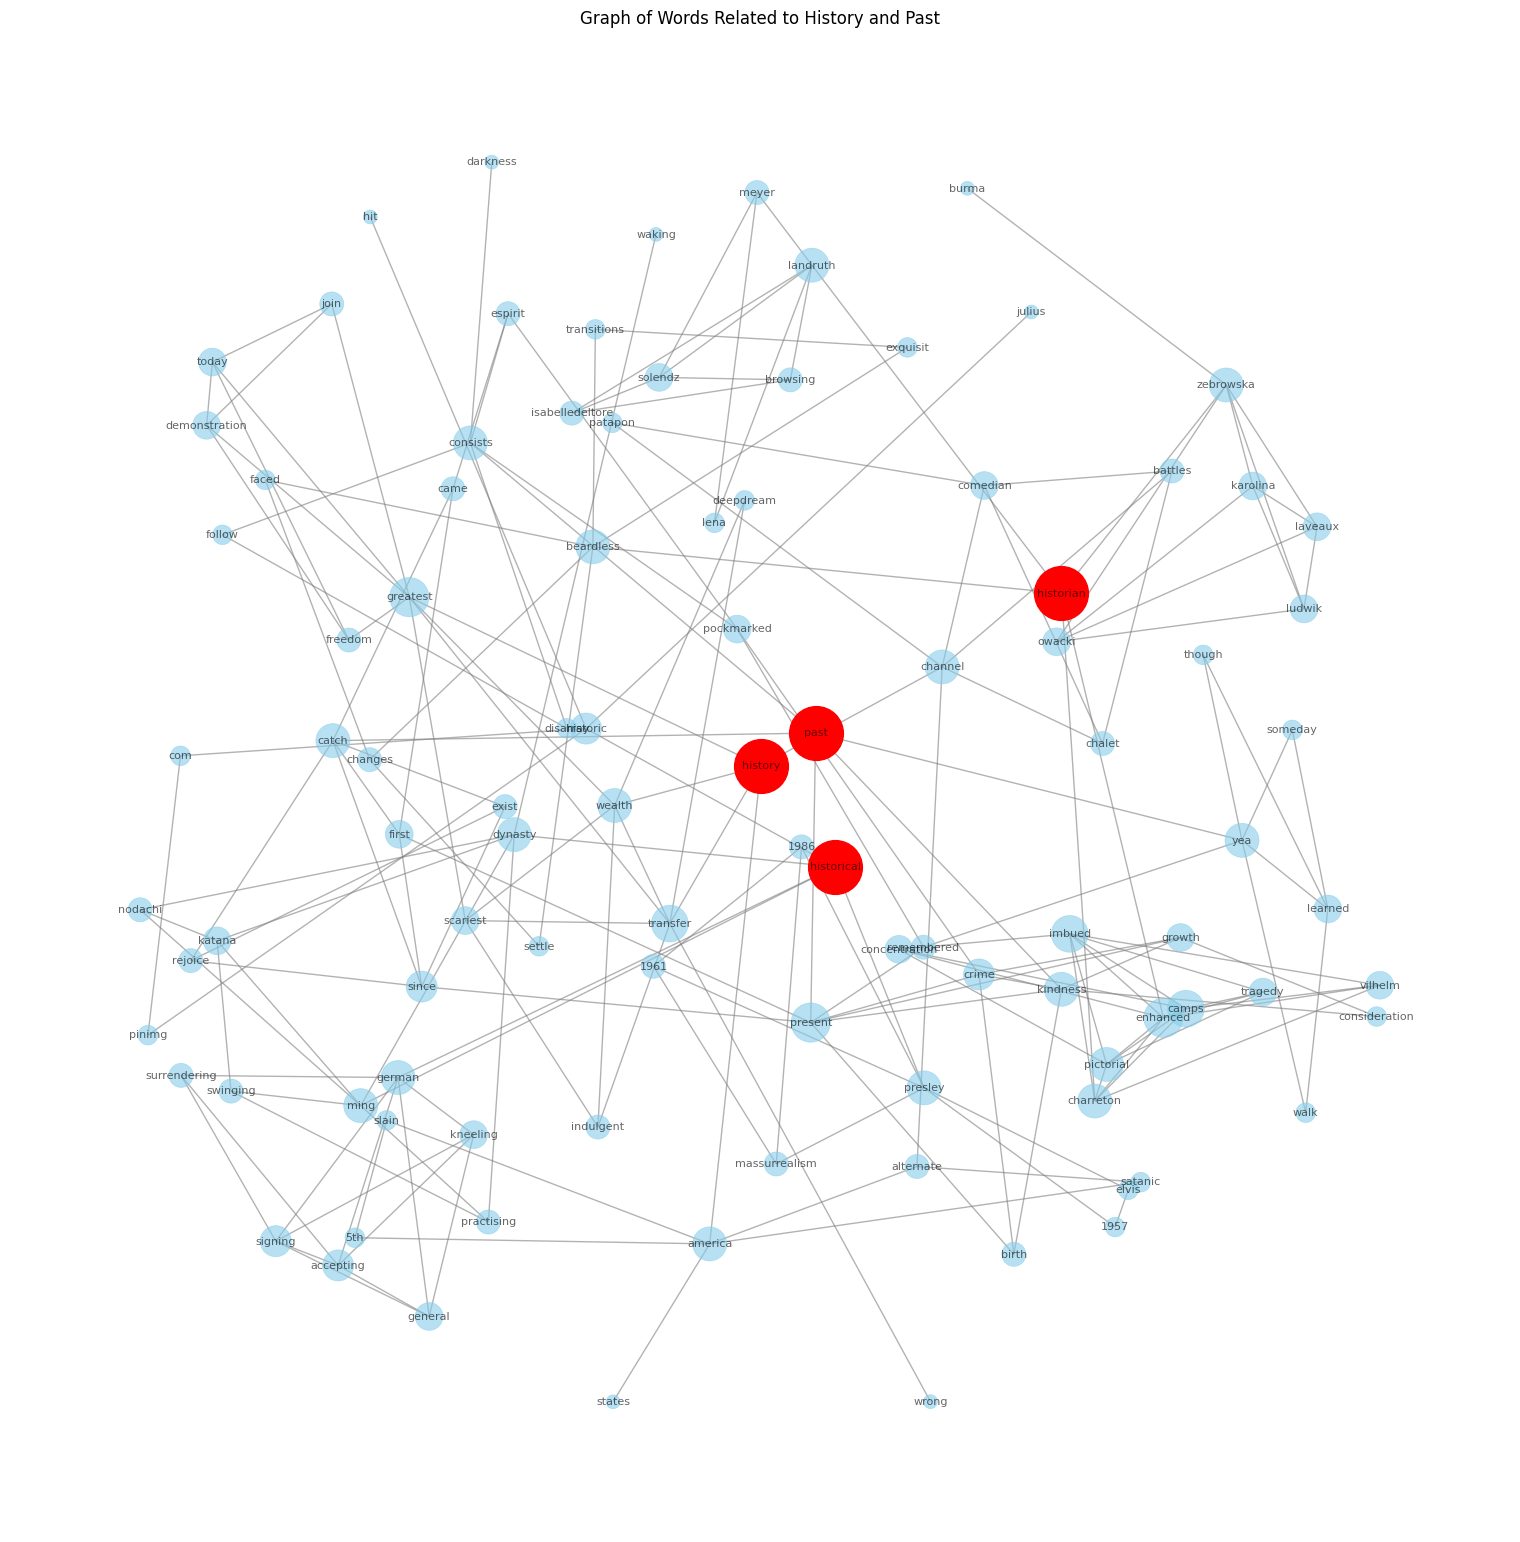

In [19]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the seed words
seed_words = ['history', 'historical', 'historian', 'past']

# Create a graph
G = nx.Graph()

# Function to get related words
def get_related_words(word, model, depth=2):
    related = set([word])
    for _ in range(depth):
        new_words = set()
        for w in related:
            if w in model.wv:
                similar_words = model_w2v.wv.most_similar(w, topn=5)
                new_words.update([sw for sw, _ in similar_words])
        related.update(new_words)
    return related

# Get related words and add nodes and edges
all_related_words = set()
for seed in seed_words:
    related = get_related_words(seed, model_w2v)
    all_related_words.update(related)

G.add_nodes_from(all_related_words)

for word in all_related_words:
    if word in model_w2v.wv:
        similar_words = model_w2v.wv.most_similar(word, topn=5)
        for similar_word, similarity in similar_words:
            if similar_word in all_related_words:
                G.add_edge(word, similar_word, weight=similarity)

# Plot the graph
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Adjust k for more spread out graph
plt.figure(figsize=(15, 15))

# Calculate node sizes based on degree
degrees = dict(G.degree())
node_sizes = [v * 100 for v in degrees.values()]  # Multiply by 100 to make sizes more visible

nx.draw(G, pos, with_labels=True, font_size=8,
        node_size=node_sizes,  # Use the calculated node sizes
        font_color='black', node_color='skyblue', edge_color='gray',
        linewidths=0.5, alpha=0.6)

# Add seed words with different color
nx.draw_networkx_nodes(G, pos, nodelist=seed_words, node_color='red', node_size=1500)

plt.title('Graph of Words Related to History and Past')
plt.axis('off')
plt.tight_layout()
plt.show()

# export the graph
nx.write_gexf(G, "data_generated/history_related_words_network.gexf")

/var/folders/90/j99p488148vcmjxgs16_mq0j42556r/T/ipykernel_54310/182967109.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


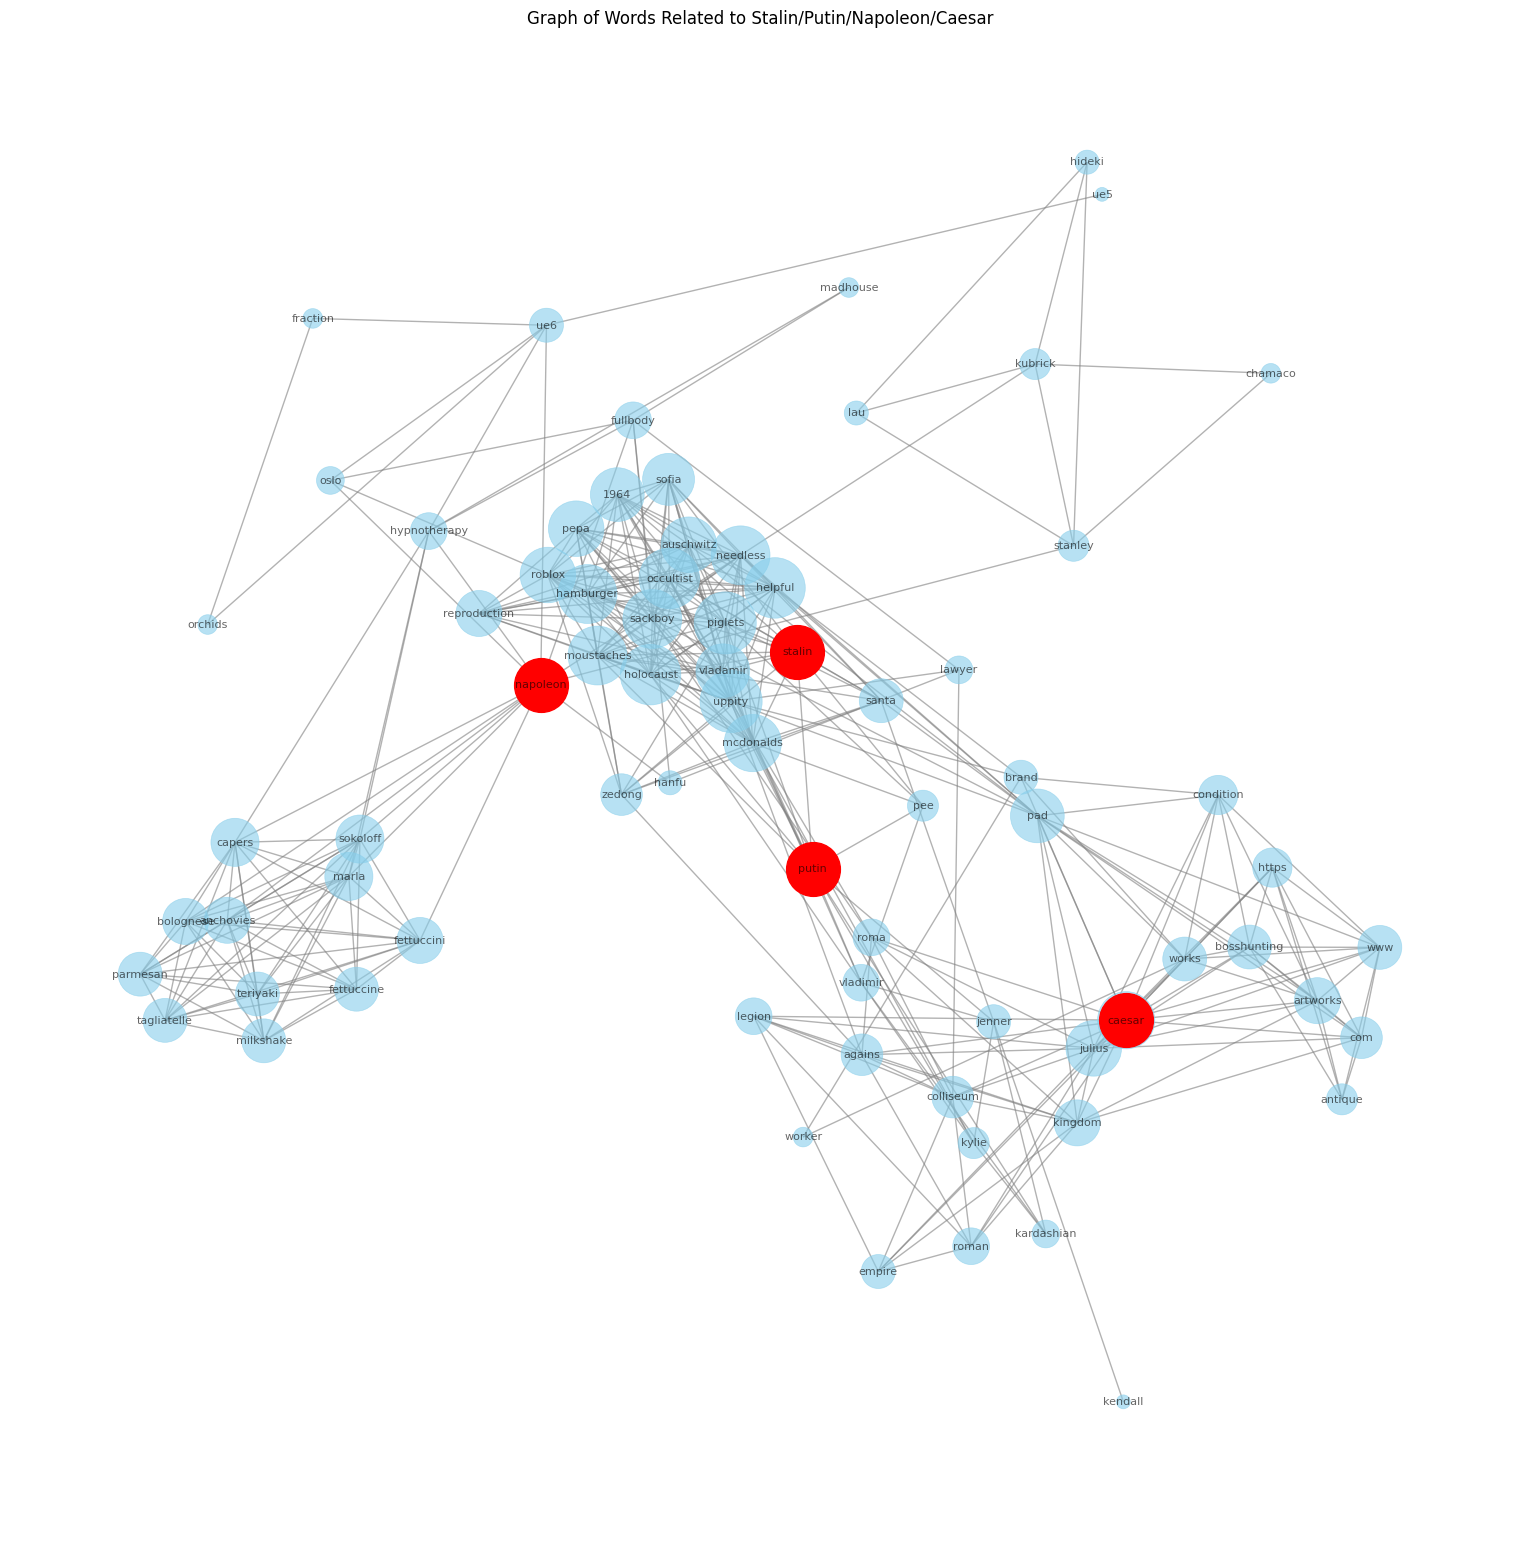

In [20]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the seed words
seed_words = ['stalin', 'putin', 'napoleon', 'caesar']

# Create a graph
G = nx.Graph()

# Function to get related words
def get_related_words(word, model, depth=2):
    related = set([word])
    for _ in range(depth):
        new_words = set()
        for w in related:
            if w in model.wv:
                similar_words = model_w2v.wv.most_similar(w, topn=5)
                new_words.update([sw for sw, _ in similar_words])
        related.update(new_words)
    return related

# Get related words and add nodes and edges
all_related_words = set()
for seed in seed_words:
    related = get_related_words(seed, model_w2v)
    all_related_words.update(related)

G.add_nodes_from(all_related_words)

for word in all_related_words:
    if word in model_w2v.wv:
        similar_words = model_w2v.wv.most_similar(word, topn=40)
        for similar_word, similarity in similar_words:
            if similar_word in all_related_words:
                G.add_edge(word, similar_word, weight=similarity)

# Plot the graph
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Adjust k for more spread out graph
plt.figure(figsize=(15, 15))

# Calculate node sizes based on degree
degrees = dict(G.degree())
node_sizes = [v * 100 for v in degrees.values()]  # Multiply by 100 to make sizes more visible

nx.draw(G, pos, with_labels=True, font_size=8,
        node_size=node_sizes,  # Use the calculated node sizes
        font_color='black', node_color='skyblue', edge_color='gray',
        linewidths=0.5, alpha=0.6)

# Add seed words with different color
nx.draw_networkx_nodes(G, pos, nodelist=seed_words, node_color='red', node_size=1500)

plt.title('Graph of Words Related to Stalin/Putin/Napoleon/Caesar')
plt.axis('off')
plt.tight_layout()
plt.show()

# Optionally, export the graph
nx.write_gexf(G, "data_generated/grandshommesalacon_related_words_network.gexf")

### Let's try some viz

(ideas from Claude)

1. t-SNE or UMAP plot:

   - Reduce the high-dimensional word vectors to 2D or 3D using t-SNE or UMAP.
   - Plot the resulting points, with each point representing a word.
   - This allows you to see clusters of semantically related words.

2. Word similarity heatmap:

   - Choose a set of words and compute their pairwise cosine similarities.
   - Create a heatmap where color intensity represents similarity.


3. Word analogy visualization:

   - Illustrate word analogies (e.g., "king" - "man" + "woman" ≈ "queen").
   - Plot the vectors and their relationships in 2D or 3D space.


4. Principal Component Analysis (PCA):

   - Apply PCA to reduce dimensionality and visualize the first few principal components.
   - This can reveal the most important directions of variance in the embedding space.


5. Word clouds based on similarity:

   - For a given word, create a word cloud of its most similar words.
   - Size words based on their similarity scores.


6. Vector arithmetic visualization:

   - Show how vector addition and subtraction work in the embedding space.
   - Visualize examples like "France" + "capital" ≈ "Paris".


7. Semantic fields:

    - Choose a domain (e.g., "animals", "emotions") and visualize related words.
    - Use dimensionality reduction to plot these words in 2D or 3D.


8. Hierarchical clustering dendrogram:

   - Perform hierarchical clustering on a subset of words.
   - Visualize the resulting dendrogram to show word relationships.


9. Word trajectory analysis:

If you have embeddings from different time periods, visualize how word meanings change over time.


10. Bias visualization:

Explore and visualize potential biases in the embeddings (e.g., gender or racial biases).

#### t-SNE or UMAP plot

In [21]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from plotly.offline import plot

# Assuming model_w2v is your Word2Vec model
model = model_w2v

# Seed words
seed_words = ["history", "historian", "historical", "past", "time"]

# Function to get similar words
def get_similar_words(model, word, n=100):
    try:
        similar_words = [word[0] for word in model.wv.most_similar(word, topn=n)]
        return similar_words
    except KeyError:
        return []  # Return empty list if word not in vocabulary

# Collect words
words = set(seed_words)
for seed in seed_words:
    words.update(get_similar_words(model, seed, n=200))  # Get 200 similar words for each seed
words = list(words)[:1000]  # Limit to 1000 words

# Get vectors
vectors = [model.wv[word] for word in words]

# Convert to numpy array
vectors = np.array(vectors)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
vectors_tsne = tsne.fit_transform(vectors)

# Create a color map: seed words in red, others in blue
colors = ['red' if word in seed_words else 'blue' for word in words]

# Create text labels: only for seed words
text_labels = [word if word in seed_words else "" for word in words]

# Create the scatter plot
trace = go.Scatter(
    x=vectors_tsne[:, 0],
    y=vectors_tsne[:, 1],
    mode='markers+text',
    text=text_labels,
    hovertext=words,
    hoverinfo='text',
    marker=dict(
        size=5,
        color=colors,
        opacity=0.8
    ),
    textposition="top center",
    textfont=dict(size=9),
    showlegend=False
)

# Create the layout
layout = go.Layout(
    title="Interactive t-SNE visualization of word embeddings<br>Seed words: " + ", ".join(seed_words),
    hovermode='closest',
    xaxis=dict(title='t-SNE dimension 1', showticklabels=False),
    yaxis=dict(title='t-SNE dimension 2', showticklabels=False)
)

# Create the figure and plot
fig = go.Figure(data=[trace], layout=layout)
plot(fig, filename='word_embeddings_tsne.html')

/Users/frederic.clavert/anaconda3/envs/vrd/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning:


Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md




'word_embeddings_tsne.html'

#### heatmaps

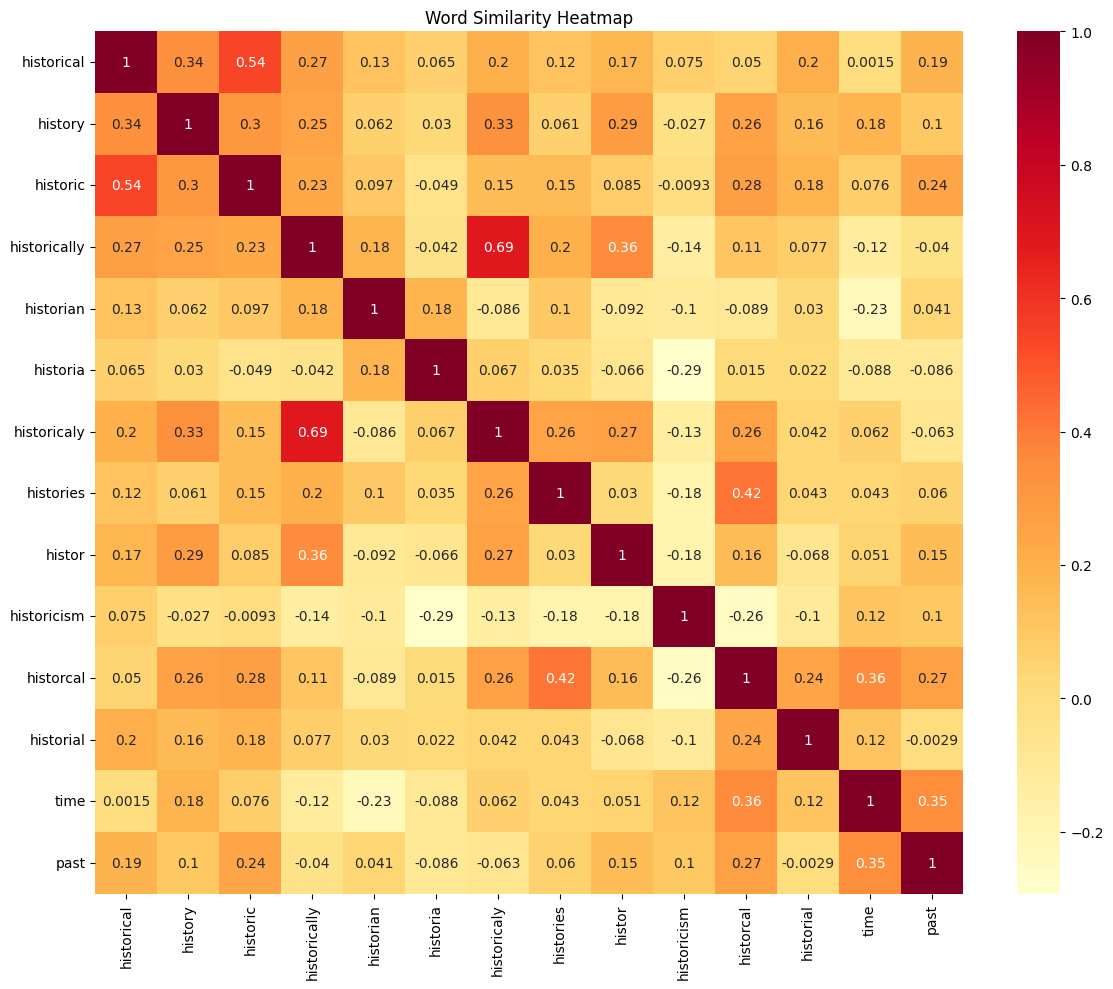

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Assuming model_w2v is your Word2Vec model
model = model_w2v

# Function to get words starting with a prefix
def get_words_with_prefix(model, prefix):
    return [word for word in model.wv.key_to_index.keys() if word.startswith(prefix)]

# Get words starting with 'histor'
histor_words = get_words_with_prefix(model, 'histor')

# Add 'time' and 'past' to the list
words = histor_words + ['time', 'past']

# Limit to top 15 most frequent words if the list is too long
if len(words) > 15:
    word_frequencies = [(word, model.wv.get_vecattr(word, "count")) for word in words]
    word_frequencies.sort(key=lambda x: x[1], reverse=True)
    words = [word for word, freq in word_frequencies[:15]]

# Compute word vectors
word_vectors = [model.wv[word] for word in words]

# Compute pairwise cosine similarities
similarity_matrix = cosine_similarity(word_vectors)

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, annot=True, cmap='YlOrRd', xticklabels=words, yticklabels=words)
plt.title("Word Similarity Heatmap")
plt.tight_layout()
plt.show()

#### Word analogy visualization

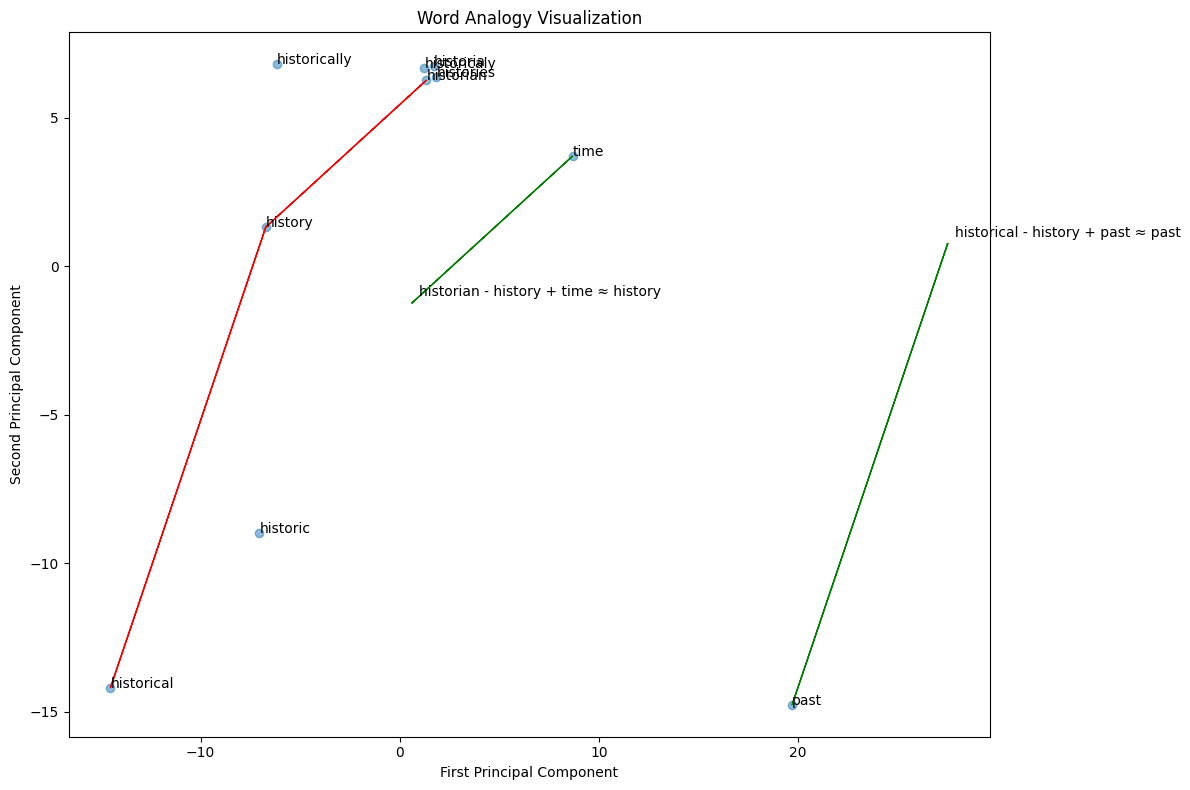

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming model_w2v is your Word2Vec model
model = model_w2v

# Function to get words starting with a prefix
def get_words_with_prefix(model, prefix):
    return [word for word in model.wv.key_to_index.keys() if word.startswith(prefix)]

# Get words starting with 'histor'
histor_words = get_words_with_prefix(model, 'histor')

# Add 'time' and 'past' to the list
words = histor_words + ['time', 'past']

# Limit to top 10 most frequent words if the list is too long
if len(words) > 10:
    word_frequencies = [(word, model.wv.get_vecattr(word, "count")) for word in words]
    word_frequencies.sort(key=lambda x: x[1], reverse=True)
    words = [word for word, freq in word_frequencies[:10]]

# Compute word vectors
word_vectors = [model.wv[word] for word in words]

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Plot words
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.5)

# Annotate words
for i, word in enumerate(words):
    plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

# Perform and plot analogies
def plot_analogy(w1, w2, w3):
    v1 = model.wv[w1]
    v2 = model.wv[w2]
    v3 = model.wv[w3]
    v_analogy = v3 - v1 + v2
    
    # Project the analogy vector to 2D
    v_analogy_2d = pca.transform([v_analogy])[0]
    
    # Plot the analogy
    plt.arrow(word_vectors_2d[words.index(w1), 0], word_vectors_2d[words.index(w1), 1],
              word_vectors_2d[words.index(w2), 0] - word_vectors_2d[words.index(w1), 0],
              word_vectors_2d[words.index(w2), 1] - word_vectors_2d[words.index(w1), 1],
              color='r', width=0.001, head_width=0.02)
    plt.arrow(word_vectors_2d[words.index(w3), 0], word_vectors_2d[words.index(w3), 1],
              v_analogy_2d[0] - word_vectors_2d[words.index(w3), 0],
              v_analogy_2d[1] - word_vectors_2d[words.index(w3), 1],
              color='g', width=0.001, head_width=0.02)
    
    # Find the closest word to the analogy
    closest_word = model.wv.most_similar([v_analogy], topn=1)[0][0]
    plt.annotate(f"{w1} - {w2} + {w3} ≈ {closest_word}", 
                 (v_analogy_2d[0], v_analogy_2d[1]), 
                 xytext=(5, 5), textcoords='offset points')

# Perform a few analogies
if 'historian' in words and 'history' in words and 'time' in words:
    plot_analogy('historian', 'history', 'time')
if 'historical' in words and 'history' in words and 'past' in words:
    plot_analogy('historical', 'history', 'past')

plt.title("Word Analogy Visualization")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.tight_layout()
plt.show()

#### PCA of Word Embeddings

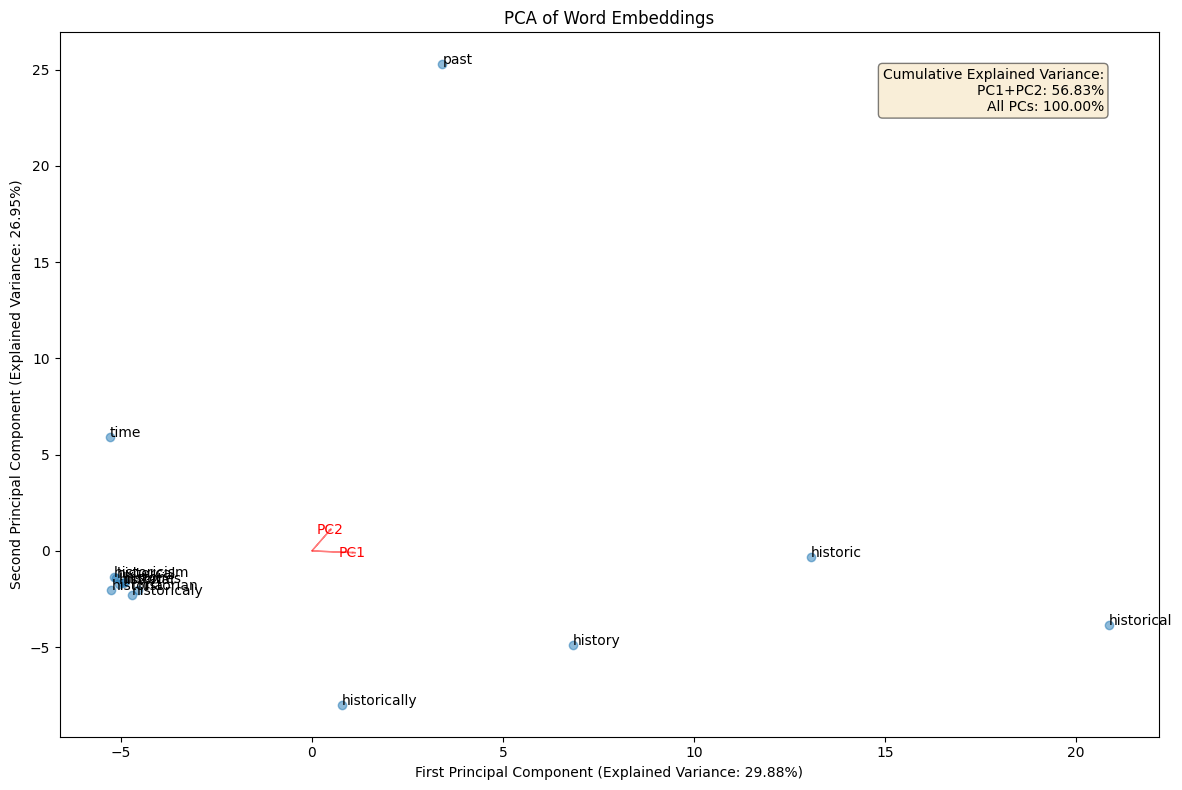

IndexError: list index out of range

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming model_w2v is your Word2Vec model
model = model_w2v

# Function to get words starting with a prefix
def get_words_with_prefix(model, prefix):
    return [word for word in model.wv.key_to_index.keys() if word.startswith(prefix)]

# Get words starting with 'histor'
histor_words = get_words_with_prefix(model, 'histor')

# Add 'time' and 'past' to the list
words = histor_words + ['time', 'past']

# Limit to top 20 most frequent words if the list is too long
if len(words) > 20:
    word_frequencies = [(word, model.wv.get_vecattr(word, "count")) for word in words]
    word_frequencies.sort(key=lambda x: x[1], reverse=True)
    words = [word for word, freq in word_frequencies[:20]]

# Compute word vectors
word_vectors = np.array([model.wv[word] for word in words])

# Apply PCA
pca = PCA()
word_vectors_pca = pca.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(12, 8))

# Scatter plot of words in PC1 and PC2 space
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], alpha=0.5)

# Annotate words
for i, word in enumerate(words):
    plt.annotate(word, (word_vectors_pca[i, 0], word_vectors_pca[i, 1]))

# Plot the principal component directions
scale = np.max(np.abs(word_vectors_pca[:, :2])) / 2
for i in range(2):
    plt.arrow(0, 0, scale * pca.components_[i, 0], scale * pca.components_[i, 1],
              color='r', alpha=0.5, head_width=0.05, head_length=0.1)
    plt.text(scale * pca.components_[i, 0], scale * pca.components_[i, 1], f'PC{i+1}',
             color='r', ha='center', va='center')

plt.title("PCA of Word Embeddings")
plt.xlabel(f"First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})")

# Add a text box with cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.text(0.95, 0.95, f"Cumulative Explained Variance:\nPC1+PC2: {cumulative_variance[1]:.2%}\nAll PCs: {cumulative_variance[-1]:.2%}",
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print top words contributing to each principal component
def print_top_words_per_pc(pca, words, n_components=2, n_top_words=5):
    for i in range(min(n_components, len(words))):
        sorted_indices = np.argsort(np.abs(pca.components_[i]))[::-1]
        top_words = [words[idx] for idx in sorted_indices[:min(n_top_words, len(words))]]
        print(f"Top words for PC{i+1}: {', '.join(top_words)}")

print_top_words_per_pc(pca, words)



#### Wordclouds of words similar to another word

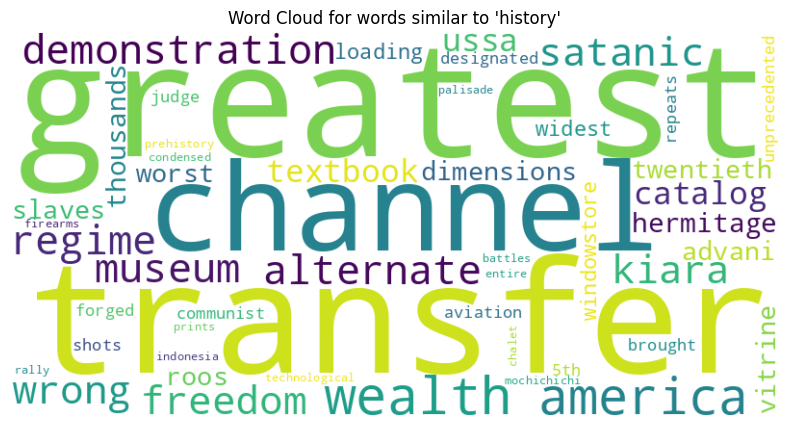

Top 10 words most similar to 'history':
greatest: 0.5447
transfer: 0.5289
channel: 0.5191
wealth: 0.5180
america: 0.4888
regime: 0.4869
alternate: 0.4865
museum: 0.4792
demonstration: 0.4735
kiara: 0.4542


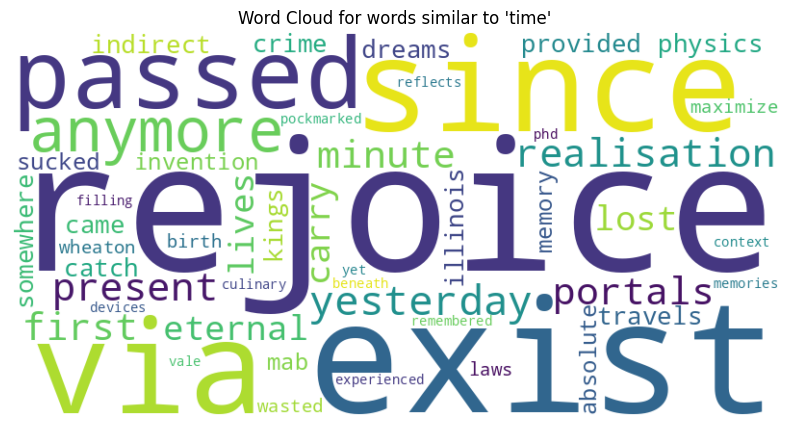

Top 10 words most similar to 'time':
rejoice: 0.7116
exist: 0.7030
since: 0.6931
via: 0.6899
passed: 0.6889
anymore: 0.6705
yesterday: 0.6699
realisation: 0.6481
present: 0.6404
portals: 0.6140


In [25]:

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# Assuming model_w2v is your Word2Vec model
model = model_w2v

def create_similarity_wordcloud(model, word, n=50):
    # Get similar words
    similar_words = model.wv.most_similar(word, topn=n)
    
    # Create a dictionary of words and their similarity scores
    word_score_dict = {word: score for word, score in similar_words}
    
    # Create and generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          min_font_size=10).generate_from_frequencies(word_score_dict)
    
    # Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for words similar to '{word}'")
    plt.show()
    
    # Print top 10 similar words with their scores
    print(f"Top 10 words most similar to '{word}':")
    for similar_word, score in similar_words[:10]:
        print(f"{similar_word}: {score:.4f}")

# Create word clouds for 'history' and 'time'
create_similarity_wordcloud(model, 'history')
create_similarity_wordcloud(model, 'time')

#### Hierachical Clustering Dendrogram of words

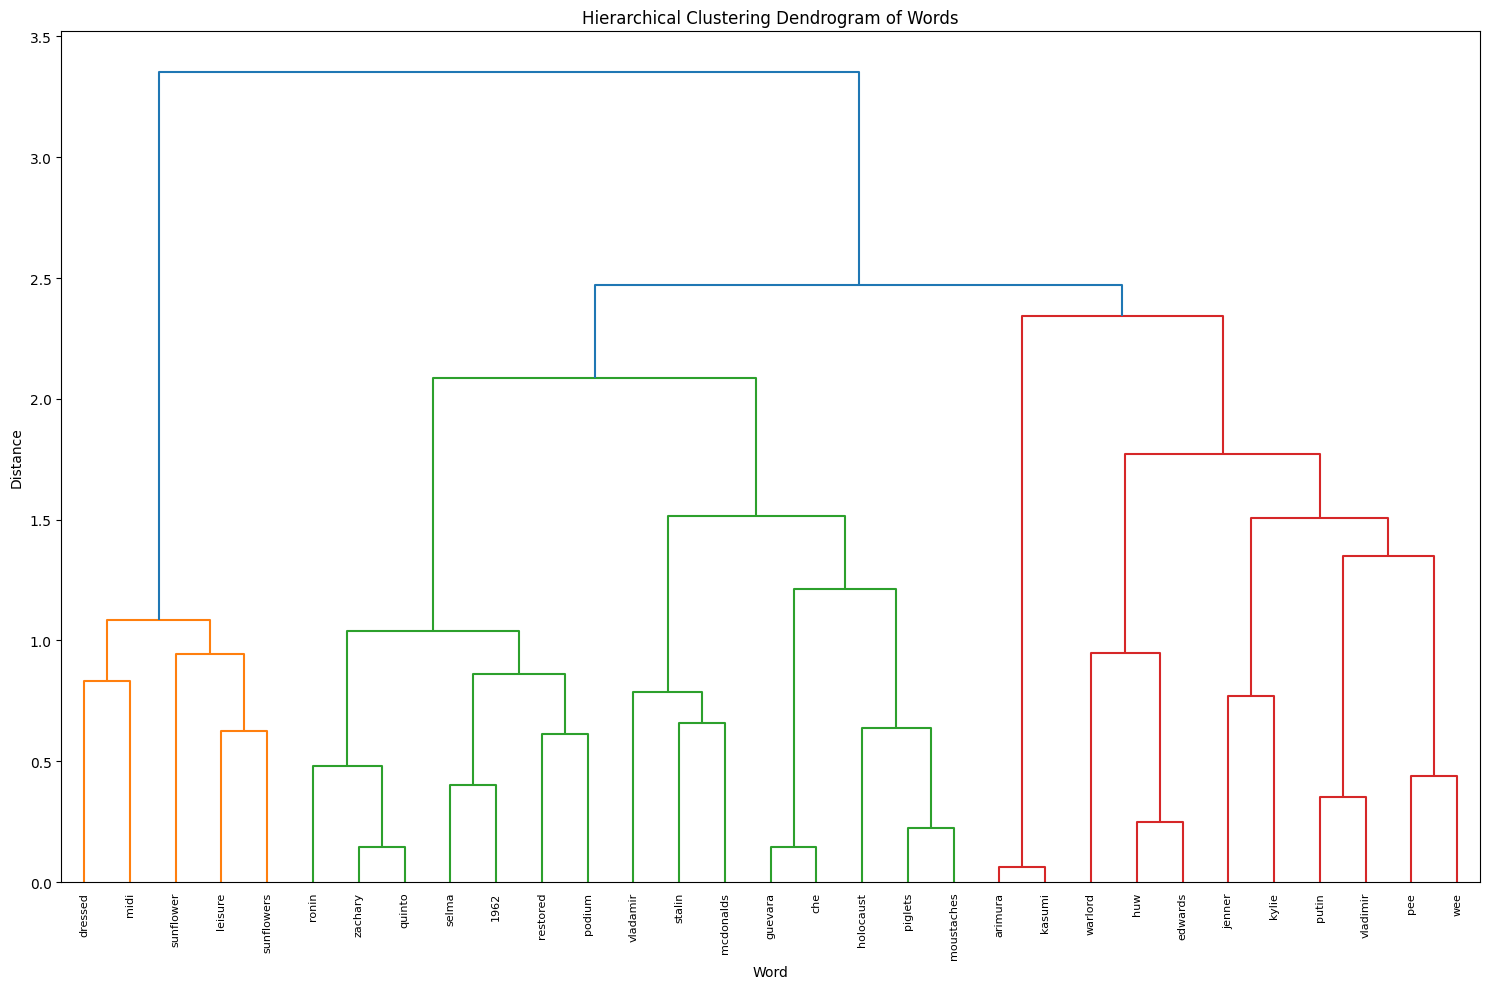

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity

# Assuming model_w2v is your Word2Vec model
model = model_w2v

def get_related_words(model, seed_word, n=30):
    """Get words related to the seed word"""
    related = model.wv.most_similar(seed_word, topn=n)
    words = [seed_word] + [word for word, _ in related]
    return words

def create_hierarchical_clustering_dendrogram(model, words):
    # Get word vectors
    vectors = np.array([model.wv[word] for word in words])
    
    # Compute cosine similarity
    similarity_matrix = cosine_similarity(vectors)
    
    # Convert similarity to distance
    distance_matrix = 1 - similarity_matrix
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(distance_matrix, method='ward')
    
    # Create dendrogram
    plt.figure(figsize=(15, 10))
    dendrogram(linkage_matrix, labels=words, leaf_rotation=90, leaf_font_size=8)
    plt.title("Hierarchical Clustering Dendrogram of Words")
    plt.xlabel("Word")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

# Get words related to 'history'
history_words = get_related_words(model, 'putin', n=30)

# Create and display the dendrogram
create_hierarchical_clustering_dendrogram(model, history_words)